In [32]:
import sys
import os
print(os.getcwd())
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from PIL import Image
import numpy as np

# Add parent directory to the system path
sys.path.append(os.path.abspath(".."))

# Import custom modules
from model_unet import ReconstructiveSubNetwork, DiscriminativeSubNetwork
# from data_loader import MVTecDRAEMTestDataset


/home/sameerhashmi36/Documents/AVS7/anomaly_detection_computer_vision/DRAEM/testing


In [33]:
# Dataset Class
class TestingMVTecDataset(Dataset):
    def __init__(self, test_dir, ground_truth_dir, transform=None):
        """
        Custom dataset for testing MVTec data.

        Parameters:
        - test_dir: Path to the test images folder.
        - ground_truth_dir: Path to the ground truth masks folder.
        - transform: Transformations to apply to the test images.
        """
        self.test_dir = test_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform
        self.data = []

        # Iterate through all subfolders (broken_large, broken_small, contamination, good)
        for subfolder in os.listdir(test_dir):
            test_subfolder = os.path.join(test_dir, subfolder)
            gt_subfolder = os.path.join(ground_truth_dir, subfolder) if subfolder != "good" else None

            if os.path.isdir(test_subfolder):
                for img_file in os.listdir(test_subfolder):
                    if img_file.endswith(".png"):
                        test_img_path = os.path.join(test_subfolder, img_file)

                        if subfolder == "good":
                            # Assign a dummy ground truth mask for normal samples
                            gt_mask_path = None
                        else:
                            # Assign ground truth mask for anomalous samples
                            gt_mask_path = os.path.join(gt_subfolder, img_file.replace(".png", "_mask.png"))

                        # Add only valid entries
                        if os.path.isfile(test_img_path) and (gt_mask_path is None or os.path.isfile(gt_mask_path)):
                            self.data.append((test_img_path, gt_mask_path))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        test_img_path, gt_mask_path = self.data[idx]

        # Load test image
        test_image = Image.open(test_img_path).convert("RGB")

        # Load ground truth mask
        if gt_mask_path is None:
            ground_truth_mask = Image.new("L", test_image.size)  # Create an all-zeros mask
        else:
            ground_truth_mask = Image.open(gt_mask_path).convert("L")

        # Apply transformations
        if self.transform:
            test_image = self.transform(test_image)
            ground_truth_mask = self.transform(ground_truth_mask)

        return test_image, ground_truth_mask, test_img_path

In [34]:
# Define paths
test_image_dir = "../../datasets/mvtec/bottle/test/"
ground_truth_dir = "../../datasets/mvtec/bottle/ground_truth"

In [35]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [36]:
# Initialize the dataset and DataLoader
test_dataset = TestingMVTecDataset(test_dir=test_image_dir, ground_truth_dir=ground_truth_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Validate Class Distribution
normal_count = sum(1 for _, gt_mask, _ in test_loader.dataset if gt_mask.max() == 0)
anomalous_count = sum(1 for _, gt_mask, _ in test_loader.dataset if gt_mask.max() > 0)
print(f"Normal samples (good): {normal_count}")
print(f"Anomalous samples: {anomalous_count}")

Normal samples (good): 20
Anomalous samples: 63


In [37]:
# Visualization Function
def visualize_results(input_image, gt_mask, predicted_mask, idx):
    input_image = input_image.cpu().numpy().transpose(1, 2, 0)
    gt_mask = gt_mask.cpu().numpy().squeeze()
    predicted_mask = predicted_mask.cpu().numpy().squeeze()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_image)
    axes[0].set_title("Input Image")
    axes[1].imshow(gt_mask, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(predicted_mask, cmap="jet")
    axes[2].set_title("Predicted Mask")
    for ax in axes:
        ax.axis("off")
    plt.show()

In [38]:
def evaluate_model(reconstructive_model_path, discriminative_model_path, test_loader, visualize=False, num_visualizations=4):
    # Load models
    reconstructive_model = ReconstructiveSubNetwork(in_channels=3, out_channels=3)
    reconstructive_model.load_state_dict(torch.load(reconstructive_model_path))
    reconstructive_model.cuda()
    reconstructive_model.eval()

    discriminative_model = DiscriminativeSubNetwork(in_channels=6, out_channels=2)
    discriminative_model.load_state_dict(torch.load(discriminative_model_path))
    discriminative_model.cuda()
    discriminative_model.eval()

    # Metrics storage
    total_pixel_scores = []
    total_gt_pixel_scores = []
    anomaly_score_gt = []
    anomaly_score_prediction = []

    with torch.no_grad():
        for idx, (input_image, gt_mask, img_path) in enumerate(tqdm(test_loader, desc="Testing")):
            # Process inputs
            input_image = input_image.cuda()
            gt_mask = gt_mask.cuda()

            # Determine anomaly presence
            has_anomaly = 1 if gt_mask.max() > 0 else 0
            anomaly_score_gt.append(has_anomaly)

            # Reconstructive Model
            reconstructed_image = reconstructive_model(input_image)

            # Combine reconstructed and input for segmentation
            joined_input = torch.cat((reconstructed_image, input_image), dim=1)
            segmentation_output = discriminative_model(joined_input)
            segmentation_output_sm = torch.softmax(segmentation_output, dim=1)

            # Anomaly score for image-level metric
            anomaly_score_prediction.append(segmentation_output_sm[:, 1, :, :].max().item())

            # Flatten ground truth and predicted masks for pixel-level metrics
            flat_gt = gt_mask.view(-1).cpu().numpy()
            flat_pred = segmentation_output_sm[:, 1, :, :].view(-1).cpu().numpy()
            total_gt_pixel_scores.extend(flat_gt)
            total_pixel_scores.extend(flat_pred)

            # Visualize results
            if visualize and idx < num_visualizations:
                visualize_results(input_image[0], gt_mask[0], segmentation_output_sm[0, 1, :, :], idx)

    # Handle edge cases where one class is missing
    # print(f"Unique values in anomaly_score_gt: {np.unique(anomaly_score_gt, return_counts=True)}")
    if len(np.unique(anomaly_score_gt)) < 2:
        # print("Dataset contains only one class. Skipping AUC calculation.")
        return None, None, None, None

    # print(f"Unique values in total_gt_pixel_scores before thresholding: {np.unique(total_gt_pixel_scores)}")
    total_gt_pixel_scores = (np.array(total_gt_pixel_scores) > 0.5).astype(int)

    if len(np.unique(total_gt_pixel_scores)) < 2:
        # print(f"Unique pixel-level ground truth values: {np.unique(total_gt_pixel_scores, return_counts=True)}")
        # print("Dataset contains only one class in ground truth. Skipping pixel-level AUC calculation.")
        return None, None, None, None

    # Metrics calculation
    image_auc = roc_auc_score(anomaly_score_gt, anomaly_score_prediction)
    image_ap = average_precision_score(anomaly_score_gt, anomaly_score_prediction)

    total_pixel_scores = np.array(total_pixel_scores)

    pixel_auc = roc_auc_score(total_gt_pixel_scores, total_pixel_scores)
    pixel_ap = average_precision_score(total_gt_pixel_scores, total_pixel_scores)

    print(f"Image-Level AUC: {image_auc:.4f}, AP: {image_ap:.4f}")
    print(f"Pixel-Level AUC: {pixel_auc:.4f}, AP: {pixel_ap:.4f}")

    return image_auc, image_ap, pixel_auc, pixel_ap

In [39]:
# Paths to the models and test data
reconstructive_model_path = "../checkpoints/bottle_cutpaste_checkpoints/MVTec_cutpaste_0.0001_700_bs2_bottle_.pckl"
discriminative_model_path = "../checkpoints/bottle_cutpaste_checkpoints/MVTec_cutpaste_0.0001_700_bs2_bottle__seg.pckl"
# test_data_path = "../datasets/mvtec/bottle/test/"

Testing:   0%|          | 0/83 [00:00<?, ?it/s]

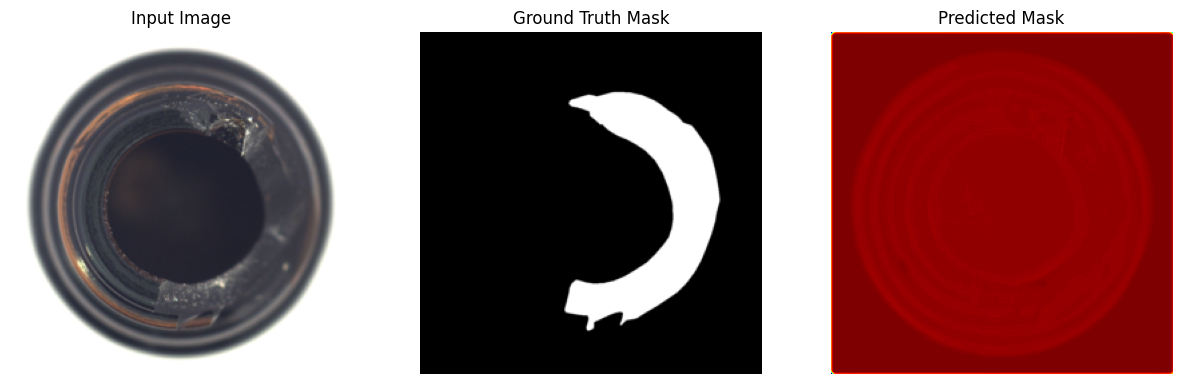

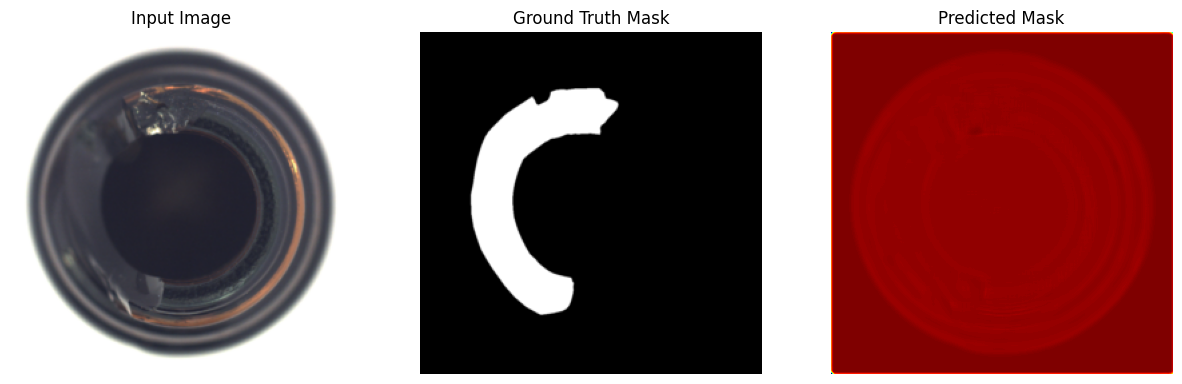

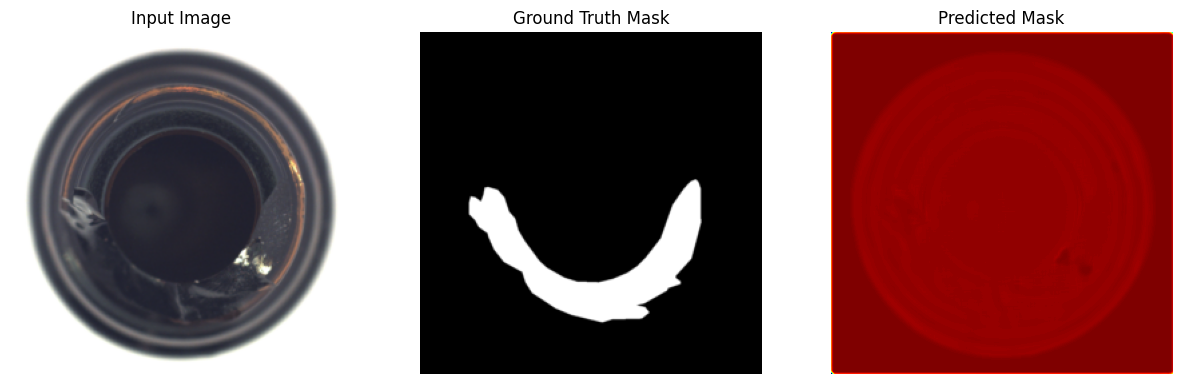

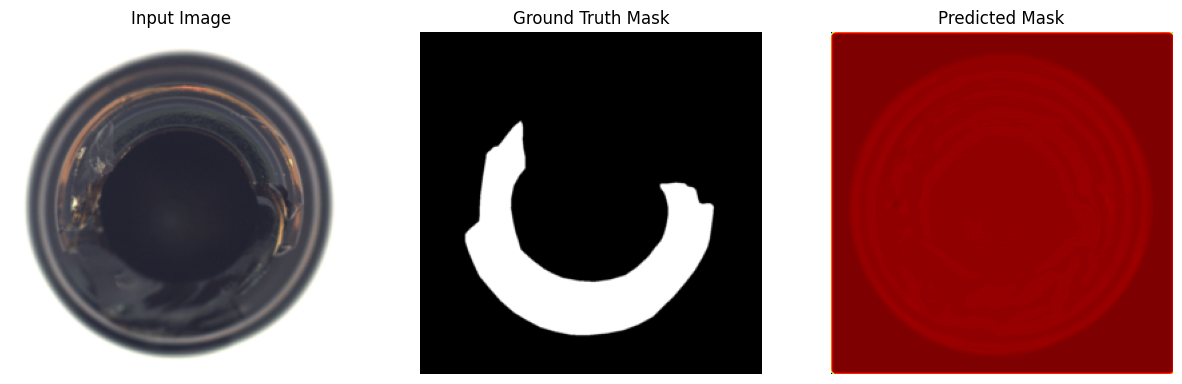

Image-Level AUC: 0.5369, AP: 0.7730
Pixel-Level AUC: 0.3338, AP: 0.0399


(0.5369047619047619,
 0.7730104089828702,
 0.33380611528944926,
 0.03985739888170549)

: 

In [40]:
evaluate_model(reconstructive_model_path, discriminative_model_path, test_loader, visualize=True)